# Espectros de variância, covariância e correlação

por [Afrânio](http://afrjr.weebly.com) - LMSCP - Laboratório de Modelagem, Simulação e Controle de Processos - PEQ/COPPE/UFRJ

06/2018

Este notebook [Jupyter](http://jupyter.org/) tem como objetivo apresentar os primeiros testes do projeto **spectra**, destinado a implementar em Python códigos para geração de espectros de variância, covariância e correlação, de acordo com as técnicas propostas por [FEITAL E PINTO, 2015](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract). A linguagem de programação utilizada é a [Python 3.6](https://www.python.org/).

In [1]:
# importando todos os módulos necessários

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## 1. Espectros de variância, covariância e correlação

### 1.1 Definições

#### 1.1.1 Espectros de variância

Um *espectro de variância* é um conjunto de variâncias calculado enquanto alguma variável a elas relacionadas evolui ([FEITAL E PINTO, 2015](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)). Neste notebook em particular, o foco está no espectro de variância calculada conforme o tamanho da janela de dados utilizados no próprio cálculo da variância aumenta.

Seja um conjunto de dados $\mathbf{x}$ de tamanho $ND$. O espectro de variância de $\mathbf{x}$, dito com *janela deslizante*, é o vetor constituído dos seguintes elementos:

$$ \sigma_{TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1}^{NJ}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2}{TJ-1}}{NJ}$$

Sendo:

* $TJ$: o tamanho da janela, que caracteriza cada ponto do espectro;
* $NJ = ND-TJ+1$: o número de janelas em cada ponto do espectro;
* $\bar{x}$: a média na janela considerada.

O tamanho de janela máximo, nesse caso, pode ser arbitrado como $ND$.

O espectro de variância de $\mathbf{x}$, dito com *janelas independentes*, é o vetor constituído dos seguintes elementos:

$$ \sigma_{TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1,TJ+1,2TJ+1...}^{(NJ-1)TJ +1}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2}{TJ-1}}{NJ}$$

sendo $NJ$ nesse caso calculado pela equação $NJ = \displaystyle\frac{ND}{TJ}$. É recomendável que o tamanho de janela máximo não ultrapasse $\displaystyle\frac{ND}{2}$.

Essas duas configurações caracterizam casos extremos. Há configurações intermediárias, não consideradas por enquanto, em que as janelas apresentam diferentes graus de acoplamento.

#### 1.1.2. Espectros de covariância

Os espectros de covariância aqui analisados são definidos da mesma forma que os espectros de variância. 

Para janela deslizante, o espectro de covariância entre dois conjuntos de dados $\mathbf{x}$ e $\mathbf{y}$ é:

$$ \sigma_{x,y,TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1}^{NJ}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2\left(y_{i}-\bar{y}\right)^2}{TJ-1}}{NJ}$$

Para janelas independentes, tem-se:

$$ \sigma_{x,y,TJ}^2 = \displaystyle\frac{\displaystyle\sum_{k=1,TJ+1,2TJ+1...}^{(NJ-1)TJ +1}\displaystyle\sum_{i=k}^{k+TJ-1} \displaystyle\frac{\left(x_{i}-\bar{x}\right)^2\left(y_{i}-\bar{y}\right)^2}{TJ-1}}{NJ}$$

#### 1.1.3 Espectros de correlação

A relação entre o coeficiente de correlação de Pearson $r_{xy}$, a variância e a covariância é:

$$r_{xy} = \frac{\sigma_{xy}^2}{\sigma_x \sigma_y}$$

O coeficiente de Pearson situa-se entre -1 e 1. Quanto mais perto de 1 o valor de $|r_{xy}|$ se encontra, maior é o grau em que os dados $x$ e $y$ variam juntos.

### 1.2 Implementação - classe spectra

Foi implementada uma classe em Python, denominada **spectra**, para o cálculo dos espectros de variância, covariância e correlação. A classe **spectra** é constituída dos seguintes métodos:

* **\__init__**: construtor da classe, que aceita como argumento os dados a serem analisados;
* **sliding_Window_Var_Spectra**: cálculo do espectro de variância utilizando janela deslizante;
* **independent_Window_Var_Spectra**: cálculo dos espectros de variância utilizando janelas independentes;
* **sliding_Window_Cov_Spectra**: cálculo dos espectros de covariância e de correlação utilizando janela deslizante;
* **independent_Window_Var_Spectra**: cálculo dos espectros de covariância e de correlação utilizando janelas independentes;
* **plot_Var_Spectra**: traçado dos espectros de variância;
* **plot_Cov_Spectra**: traçado dos espectros de covariância;
* **plot_Corr_Spectra**: traçado dos espectros de correlação .

Segue o código da classe:

In [2]:
class spectra (object):
    
    #########################
    
    def __init__ (self,data,data2=[]):
        
        # dados a serem analisados
        self.data = np.squeeze(np.asarray(data, dtype=np.float64))
        self.data2 = np.squeeze(np.asarray(data2, dtype=np.float64))
        
        # número de pontos
        self.ND = self.data.size
        self.ND2 = self.data2.size

    #########################
        
    def sliding_Window_Var_Spectra (self):
        
        # variável que armazenará o espectro
        self.spctr_var_sliding = np.zeros(self.ND)
                
        # para cada tamanho de janela...
        for TJ in range (2,self.ND):
            
            # ... calcule o número de janelas ...
            NJ = self.ND - TJ +1
            
            # ... inicialize a soma ...
            soma = 0
            
            # ... e calcule o somatorio das variâncias de cada janela
            for i in range(0,NJ):
                soma += np.var(self.data[i:i+TJ])
                
            self.spctr_var_sliding[TJ] = soma/NJ
                                            
    #########################

    def independent_Window_Var_Spectra (self):
        
        # variável que armazenará o espectro
        self.spctr_var_ind = np.zeros(int(self.ND/2))
        
        # para cada tamanho de janela...
        for TJ in range (2,int(self.ND/2)):

            # ... calcule o número de janelas ...
            NJ = int(self.ND/TJ)
            
            # ... inicialize a soma ...
            soma = 0
            
            # ... e calcule o somatorio das variâncias de cada janela
            for i in range(NJ):
                soma += np.var(self.data[i*TJ:(i+1)*TJ])
                
            self.spctr_var_ind[TJ] = soma/NJ
            
    #########################
            
    def sliding_Window_Cov_Spectra (self):
        
        # variável que armazenará o espectro
        self.spctr_cov_sliding = np.zeros(self.ND)
        self.spctr_corr_sliding = np.zeros(self.ND)
                
        # para cada tamanho de janela...
        for TJ in range (2,self.ND):
            
            # ... calcule o número de janelas ...
            NJ = self.ND - TJ +1
            
            # ... inicialize as somas ...
            soma1 = 0
            soma2 = 0
            
            # ... e calcule os somatorios das covariâncias e das correlações de cada janela
            for i in range(0,NJ):
                soma1 += np.cov(self.data[i:i+TJ],self.data2[i:i+TJ])[0,1]
                soma2 += np.corrcoef(self.data[i:i+TJ],self.data2[i:i+TJ])[0,1]

            self.spctr_cov_sliding[TJ] = soma1/NJ
            self.spctr_corr_sliding[TJ] = soma2/NJ
                                            
    #########################
    
    def independent_Window_Cov_Spectra (self):
        
        # variável que armazenará o espectro
        self.spctr_cov_ind = np.zeros(int(self.ND/2))
        self.spctr_corr_ind = np.zeros(int(self.ND/2))
        
        # para cada tamanho de janela...
        for TJ in range (2,int(self.ND/2)):

            # ... calcule o número de janelas ...
            NJ = int(self.ND/TJ)
            
            # ... inicialize a soma ...
            soma1 = 0
            soma2 = 0
            
            # ... e calcule os somatorios das covariâncias e das correlações de cada janela
            for i in range(NJ):
                soma1 += np.cov(self.data[i*TJ:(i+1)*TJ],self.data2[i*TJ:(i+1)*TJ])[0,1]
                soma2 += np.corrcoef(self.data[i*TJ:(i+1)*TJ],self.data2[i*TJ:(i+1)*TJ])[0,1]
            
            self.spctr_cov_ind[TJ] = soma1/NJ
            self.spctr_corr_ind[TJ] = soma2/NJ
                
    #########################
    
    def plot_Var_Spectra (self, ax):
                
        if hasattr (self, 'spctr_var_sliding') and hasattr (self, 'spctr_var_ind'):
        
            ax.plot(np.arange(len(self.spctr_var_sliding)),self.spctr_var_sliding,label='Janela deslizante')
            ax.plot(np.arange(len(self.spctr_var_ind)),self.spctr_var_ind,'.',label='Janelas independentes')
            
        elif hasattr (self,'spctr_var_sliding') and not hasattr (self, 'spctr_var_ind'):
              
            ax.plot(np.arange(len(self.spctr_var_sliding)),self.spctr_var_sliding)

        elif hasattr (self,'spctr_var_ind') and not hasattr (self, 'spctr_var_sliding'):
              
            ax.plot(np.arange(len(self.spctr_var_ind)),self.spctr_var_ind,'.')
                        
    #########################            
            
    def plot_Cov_Spectra (self, ax):
                
        if hasattr (self, 'spctr_cov_sliding') and hasattr (self, 'spctr_cov_ind'):
        
            ax.plot(np.arange(len(self.spctr_cov_sliding)),self.spctr_cov_sliding,label='Janela deslizante')
            ax.plot(np.arange(len(self.spctr_cov_ind)),self.spctr_cov_ind,'.',label='Janelas independentes')
            
        elif hasattr (self,'spctr_cov_sliding') and not hasattr (self, 'spctr_cov_ind'):
              
            ax.plot(np.arange(len(self.spctr_cov_sliding)),self.spctr_cov_sliding,'.')

        elif hasattr (self,'spctr_cov_ind') and not hasattr (self, 'spctr_cov_sliding'):
              
            ax.plot(np.arange(len(self.spctr_cov_ind)),self.spctr_cov_ind,'.')

    #########################            
            
    def plot_Corr_Spectra (self, ax):
                
        if hasattr (self, 'spctr_corr_sliding') and hasattr (self, 'spctr_corr_ind'):
        
            ax.plot(np.arange(len(self.spctr_corr_sliding)),self.spctr_corr_sliding,label='Janela deslizante')
            ax.plot(np.arange(len(self.spctr_corr_ind)),self.spctr_corr_ind,'.',label='Janelas independentes')
            
        elif hasattr (self,'spctr_corr_sliding') and not hasattr (self, 'spctr_corr_ind'):
              
            ax.plot(np.arange(len(self.spctr_corr_sliding)),self.spctr_corr_sliding,'.')

        elif hasattr (self,'spctr_corr_ind') and not hasattr (self, 'spctr_corr_sliding'):
              
            ax.plot(np.arange(len(self.spctr_corr_ind)),self.spctr_corr_ind,'.')

### 1.3 Testes

#### 1.3.1 Espectros de variância

#### 1.3.1.1 Teste 1

Para ilustrar o cálculo de um espectro de variância, [FEITAL E PINTO (2015)](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract) utilizam um sinal periódico simulado, dado pela função $y = \sin(t/4)$:

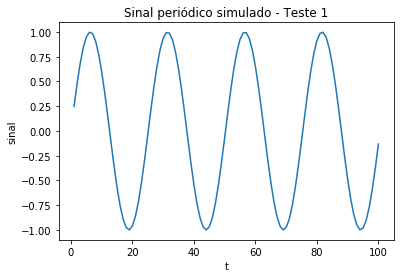

In [3]:
t = np.arange(1,101)
sinal1 = np.sin(t/4)

plt.plot(t,sinal1)
plt.title('Sinal periódico simulado - Teste 1')
plt.xlabel('t')
plt.ylabel('sinal');

Devido a abordagem de programação modular aqui utilizada, o cálculo dos espectros desse sinal constitui uma tarefa bem simples:

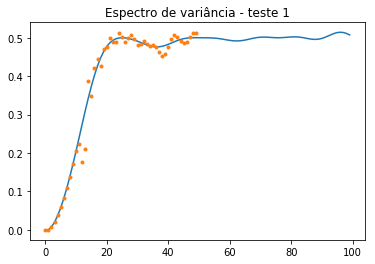

In [4]:
# criando a instância do teste 1
test1 = spectra(sinal1)

# calculando o espectro do teste 1, com janela deslizante
test1.sliding_Window_Var_Spectra()

# calculando o espectro do teste 1, com janelas independentes
test1.independent_Window_Var_Spectra()

# plotando os resultados
test1.plot_Var_Spectra(plt.gca())
plt.title('Espectro de variância - teste 1');

A curva de janela deslizante obtida é a mesma apresentada por [FEITAL E PINTO (2015)](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract).

#### 1.3.1.2 Teste 2

De modo a analisar o efeito do aumento do número de dados amostrados, mais um teste foi realizado com o mesmo sinal:

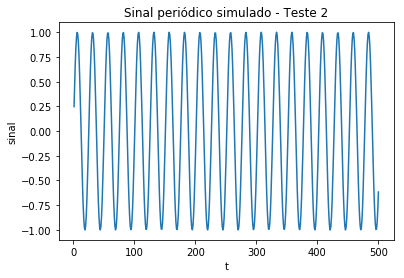

In [5]:
t = np.arange(1,501)
sinal2 = np.sin(t/4)

plt.figure()
plt.plot(t,sinal2)
plt.title('Sinal periódico simulado - Teste 2')
plt.xlabel('t')
plt.ylabel('sinal');

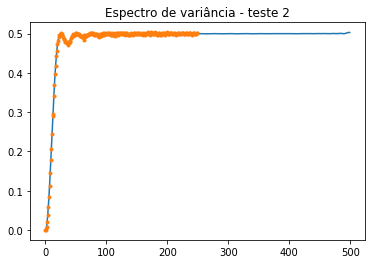

In [6]:
# criando a instância do teste 2
test2 = spectra(sinal2)

# calculando o espectro do teste 2, com janela deslizante
test2.sliding_Window_Var_Spectra()

# calculando o espectro do teste 2, com janelas independentes
test2.independent_Window_Var_Spectra()

# plotando os resultados
fig2 = test2.plot_Var_Spectra(plt.gca())
plt.title('Espectro de variância - teste 2');

Percebe-se que o espectro com janelas independentes se torna menos disperso. Esse não é um efeito meramente visual, como pode-se notar ao se focar em uma região menor do gráfico:

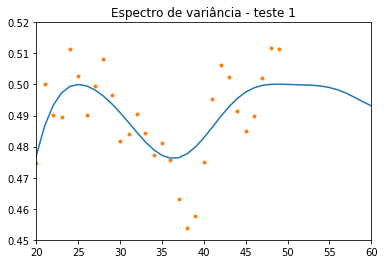

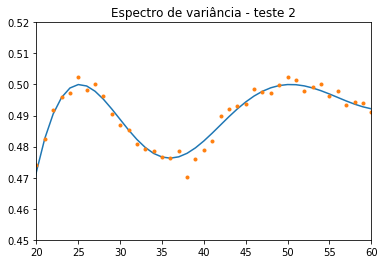

In [7]:
test1.plot_Var_Spectra(plt.gca())
plt.axis((20,60,0.45,0.52))
plt.title('Espectro de variância - teste 1')

plt.figure()

test2.plot_Var_Spectra(plt.gca())
plt.axis((20,60,0.45,0.52))
plt.title('Espectro de variância - teste 2');

#### 1.3.2 Espectros de covariância

Ao contrário da variância, não foi encontrado no caso da covariância uma referência de sinal simulado para ser utilizada com fins de comparação. Portanto, neste texto foram analisados exemplos de sinais em que se consegue prever o comportamento dos espectros.

#### 1.3.2.1 Teste 3

O teste 3 foi realizado com dois sinais lineares e totalmente correlacionados: [0,1,2,...100] e [0,3,6,...,300].

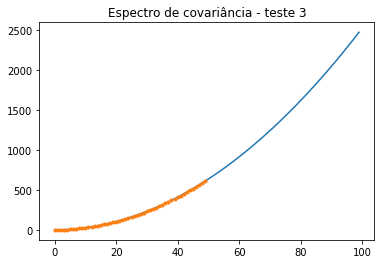

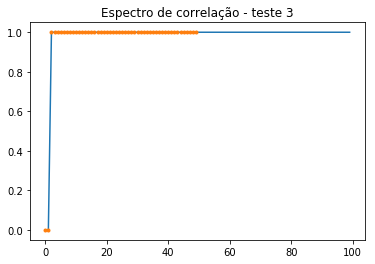

In [8]:
sinal1 = np.arange(1,101)
sinal2 = 3*sinal1

test3 = spectra(sinal1,sinal2)

test3.sliding_Window_Cov_Spectra()
test3.independent_Window_Cov_Spectra()

test3.plot_Cov_Spectra(plt.gca())
plt.title('Espectro de covariância - teste 3')

plt.figure()

test3.plot_Corr_Spectra(plt.gca())
plt.title('Espectro de correlação - teste 3');

Os resultados estão de acordo com o esperado, já que a covariância aumenta com o tamanho da janela (comportamento condizente com o caráter crescente de ambos os sinais) e a correlação é constante e vale 1.

#### 1.3.2.2 Teste 4

No teste 4, o primeiro sinal é linear e o segundo é a soma do primeiro com uma flutuação aleatória:

In [9]:
sinal1 = np.arange(1,501)
sinal2 = sinal1 + np.random.rand(sinal1.size)*sinal1

Espera-se que o espectro de covariância tenha o mesmo aspecto que o do teste 3 (já que a tendência crescente de ambos os sinais é a mesma). O espectro de correlação, no entanto, deve ser bem diferente, já que o efeito da flutuação em janelas pequenas faz com que a correlação seja significativamente baixa.

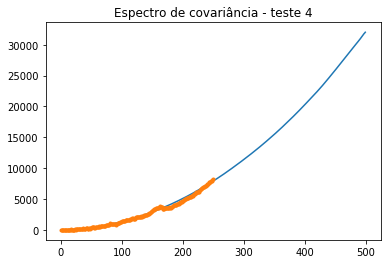

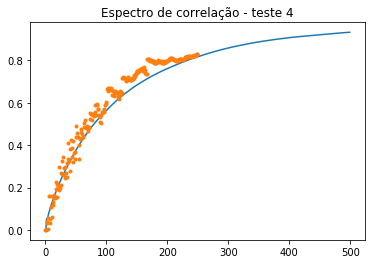

In [10]:
test4 = spectra(sinal1,sinal2)

test4.sliding_Window_Cov_Spectra()
test4.independent_Window_Cov_Spectra()

test4.plot_Cov_Spectra(plt.gca())
plt.title('Espectro de covariância - teste 4')

plt.figure()

test4.plot_Corr_Spectra(plt.gca())
plt.title('Espectro de correlação - teste 4');

O resultado é exatamente o esperado. 

É curiosa a diferença entre as suavidades dos dois espectros obtidos com janelas independentes.

#### 1.3.2.3 Teste 5

Como último exemplo, foram analisados dois sinais periódicos seno e cosseno, cuja covariância deve ser nula de acordo com um [resultado clássico da estatística](https://stats.stackexchange.com/questions/224098/correlation-between-sine-and-cosine).

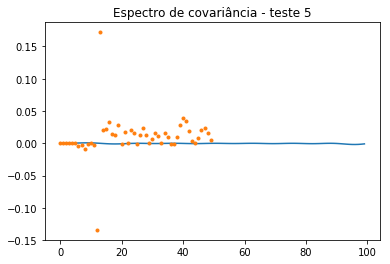

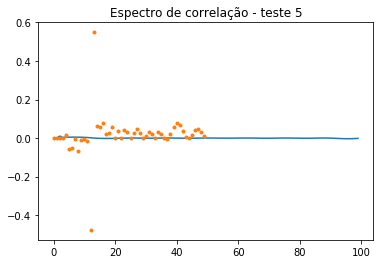

In [11]:
t = np.arange(1,101)
sinal1 = np.sin(t/4)

sinal2 = np.cos(t/4)

test5 = spectra(sinal1,sinal2)

test5.sliding_Window_Cov_Spectra()
test5.independent_Window_Cov_Spectra()

test5.plot_Cov_Spectra(plt.gca())
plt.title('Espectro de covariância - teste 5')

plt.figure()

test5.plot_Corr_Spectra(plt.gca())
plt.title('Espectro de correlação - teste 5');

É curioso notar que, no caso de janelas independentes grandes, os valores de covariância e correlação não flutuam em torno de zero com média zero, mas se mantém predominantemente positivos.

## Referência

[Thiago Feital e José Carlos Pinto - Use of variance spectra for in-line validation of process measurements in continuous processes - The Canadian Journal of Chemical Engineering - 2015. DOI: 10.1002/cjce.22219.](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)